In [1]:
import datetime
import gc
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import warnings
import scipy
from contextlib import contextmanager
from pandas.core.common import SettingWithCopyWarning
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
#from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_squared_error
from math import sqrt

warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

FEATS_EXCLUDED = ["Gun","MagazaID","MerchAltGrupID","UrunKlasmanID","SatisAdet","MerchGrup","MerchGrupID","MerchMarkaYasGrupID","BuyerGrupID","KlasmanGrupID","VucutBolge","KlasmanIklimStatu"]

In [2]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))
    
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')

def thr_to_accuracy(thr, Y_test, predictions):
    return -accuracy_score(Y_test, np.array(predictions>thr, dtype=np.int))

#from sklearn.utils import check_arrays
from sklearn.metrics import mean_absolute_error

def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true+0.00000000001))) * 100

# LightGBM GBDT with KFold or Stratified KFold
def kfold_lightgbm(params, train_df, test_df, num_folds,FEATS_EXCLUDED):
    print("Starting LightGBM. Train shape: {}".format(train_df.shape))
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=326)

    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    final_rmse = 0
    final_mape = 0
    final_mae = 0
    feats = [f for f in train_df.columns if f not in FEATS_EXCLUDED]
    clfs = []
    # k-fold
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['SatisAdet'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['SatisAdet'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['SatisAdet'].iloc[valid_idx]

        # set data structure
        lgb_train = lgb.Dataset(train_x,label=train_y,free_raw_data=False)
        lgb_test = lgb.Dataset(valid_x,label=valid_y,free_raw_data=False)

        reg = lgb.train(params,lgb_train,valid_sets=[lgb_train, lgb_test],valid_names=['train', 'valid'],
                        num_boost_round=100000,early_stopping_rounds= 100,verbose_eval=200)

        oof_preds[valid_idx] = reg.predict(valid_x, num_iteration=reg.best_iteration)
        sub_preds += reg.predict(test_df[feats], num_iteration=reg.best_iteration) / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = np.log1p(reg.feature_importance(importance_type='gain', iteration=reg.best_iteration))
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        curr_rmse = sqrt(mean_squared_error(valid_y, oof_preds[valid_idx]))
        curr_mape = mape(valid_y, oof_preds[valid_idx]) 
        curr_mae = mean_absolute_error(valid_y, oof_preds[valid_idx])
        
        #curr_rmse = roc_auc_score(valid_y, oof_preds[valid_idx])
        final_rmse += curr_rmse/num_folds
        final_mape += curr_mape/num_folds
        final_mae += curr_mae/num_folds
        print('Fold %2d rmse : %.6f' % (n_fold + 1, curr_rmse))
        print('Fold %2d mape : %.6f' % (n_fold + 1, curr_mape))
        print('Fold %2d mae : %.6f' % (n_fold + 1, curr_mae))

        del reg, train_x, train_y, valid_x, valid_y
        gc.collect()
              
    print('Averall RMSE : %.6f' % (final_rmse))
    print('Averall MAPE : %.6f' % (final_mape))
    print('Averall MAE : %.6f' % (final_mae))

    # save submission file
    #test_df.loc[:,'SatisAdet'] = sub_preds
    #test_df = test_df.reset_index()
    #test_df = test_df[['card_id', 'SatisAdet']]
    #submission_file_name = "lgbm_"+str(np.round(final_rmse,4))+".csv"
    #test_df.to_csv(DATAPATH+submission_file_name, index=False)    
        
    return sub_preds, oof_preds, feature_importance_df, final_rmse    

def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  #tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    assert len(trn_series) == len(target)
    #assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    """
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    ft_tst_series.index = tst_series.index
    """
    return add_noise(ft_trn_series, noise_level) #, add_noise(ft_tst_series, noise_level)

def missing_fun(data):
    missing_value_df = data.dtypes.to_frame("type").reset_index()
    percent_missing = data.isnull().sum() * 100 / len(data)
    nunique = data.nunique(dropna=False).values
    missing_value_df["percent_missing"] = percent_missing.values
    missing_value_df["nunique"] = nunique
    missing_value_df = missing_value_df.loc[missing_value_df.percent_missing !=0]
    missing_value_df = missing_value_df.sort_values(by="percent_missing", ascending=False)
    return missing_value_df

In [3]:
train = pd.read_csv("data/SatisiKesfet_TrainData.csv")

In [4]:
train["Markup"] = 1-train["Markup"]

In [5]:
train["SezonGrup"] = train["SezonGrup"].apply(lambda x: x.strip())
train["SezonGrup"] = train["SezonGrup"].map({'Y': 1, 'K': 0})

In [6]:
train["GunSonuDepoStok"] = train["GunSonuToplamStok"] - train["GunSonuReyonStok"]

In [7]:
klasman = pd.read_csv("data/Dim_Klasman.csv")
magaza = pd.read_csv("data/Dim_Magaza.csv")
ozelguntanimlari = pd.read_csv("data/Dim_OzelGunTanimlari.csv")
tarih = pd.read_csv("data/Dim_Tarih.csv")
meteoroloji = pd.read_csv("data/MeteorolojiDegerleri.csv")

In [8]:
train = train.merge(tarih[["Gun","Yil","Ay","Hafta","HaftaninGunu"]],"left",["Gun"])
train = train.merge(magaza[["MagazaID","SehirID"]],"left",["MagazaID"])
train = train.merge(meteoroloji,"left",["Gun","SehirID"])

In [9]:
for col in ["MinimumSicaklik","OrtalamaSicaklik","MaksimumSicaklik","YagisMiktari","KarKalinligi","Yagmur","Kar"]:
    train[col] = train.groupby("Hafta")[col].transform(lambda x: x.fillna(x.mean()))

### Feature Engineering

In [10]:
celcius = train[["SehirID","Gun","OrtalamaSicaklik"]].drop_duplicates().sort_values(["SehirID","Gun"])
celcius["FarkSicaklik"] = celcius.groupby("SehirID")["OrtalamaSicaklik"].shift(1)
celcius["FarkSicaklik"] = celcius["OrtalamaSicaklik"] - celcius["FarkSicaklik"]
celcius.loc[celcius["FarkSicaklik"].isnull(),"FarkSicaklik"] = 0
train = train.merge(celcius[["SehirID","Gun","FarkSicaklik"]],"left",["SehirID","Gun"])

### Categorical

In [11]:
train = train.merge(klasman,"left",["MerchAltGrupID","UrunKlasmanID"])

In [12]:
UrunKlasmanID = pd.read_csv("burak/UrunKlasmanID-SatisAdet_num.csv")
BuyerGrupID = pd.read_csv("burak/BuyerGrupID-SatisAdet_num.csv")
KlasmanGrupID = pd.read_csv("burak/KlasmanGrupID-SatisAdet_num.csv")
MagazaID = pd.read_csv("burak/MagazaID-SatisAdet_num.csv")
klasman = pd.read_csv("burak/klasman_num.csv")
magaza = pd.read_csv("burak/magaza_num.csv")
#tarihler = pd.read_csv("burak/tarih_num.csv")

In [13]:
train = train.merge(UrunKlasmanID,"left","UrunKlasmanID")
train = train.merge(BuyerGrupID,"left","BuyerGrupID")
train.drop("BuyerGrupID",axis=1,inplace=True)
train = train.merge(KlasmanGrupID,"left","KlasmanGrupID")
train.drop("KlasmanGrupID",axis=1,inplace=True)
train = train.merge(MagazaID,"left","MagazaID") 
train = train.merge(klasman,"left",["MerchAltGrupID","UrunKlasmanID"]) 
train = train.drop("KlasmanIklimStatu_nan",axis=1)
train = train.merge(magaza,"left","MagazaID") 
train = train.drop("CaddeAVM_Tanımsız",axis=1)

#### Ozel Gunler

In [14]:
ozel = pd.read_csv("data/ozelgun_fark.csv")

In [15]:
train = train.merge(ozel,"left","Gun")

### Weekly Predictions 

In [16]:
train = train.select_dtypes(exclude=["object"])

In [17]:
train = train.merge(tarih[["Gun","YilHafta"]],"left",["Gun"])

In [18]:
weekly = pd.read_csv("weekly_oof_post.csv")

In [19]:
train = train.merge(weekly[["YilHafta","MagazaID","MerchAltGrupID","UrunKlasmanID"]],"left",["YilHafta","MagazaID","MerchAltGrupID","UrunKlasmanID"])

In [20]:
del train["YilHafta"]
gc.collect()

214

### Model

In [21]:
# Dropping columns with highly frequent values
cols_to_drop = []
drop_values = []
for col in train.columns:
    temp = train[col].value_counts(dropna=False, normalize=1)
    if len(temp[temp>0.99].index)>0:
        cols_to_drop.append(col)
        drop_values.append(temp)  
#train.drop(cols_to_drop, axis = 1, inplace = True)
print("These columns were dropped: {} \n Since they have some values covering 99% of its all values".format(cols_to_drop))

These columns were dropped: ['SehirID_114', 'SehirID_133', 'CografiBolge_DAND', 'CografiBolge_TNSZ'] 
 Since they have some values covering 99% of its all values


In [22]:
train = train.drop(cols_to_drop, axis = 1)
gc.collect()

273

In [23]:
train_copy = train.copy()

In [54]:
# params optimized by optuna
params = {'task': 'train','objective': 'regression','metric': 'rmse','learning_rate': 0.1,'verbose': -1,'nthread':-1,
          'num_leaves': 10, 'min_data': 50, 'max_depth': 7, 'num_leaves': 31, 'min_data_in_leaf': 50, 'feature_fraction': 0.8,'bagging_fraction': 0.8,'bagging_freq': 2 }

In [ ]:
FEATS_EXCLUDED = ["Gun","MagazaID","MerchAltGrupID","UrunKlasmanID","SatisAdet","MerchGrup","MerchGrupID","MerchMarkaYasGrupID",
                  "BuyerGrupID","KlasmanGrupID","VucutBolge","KlasmanIklimStatu","gun_agg","SehirID","YilHafta"]
feats = [f for f in train.columns if f not in FEATS_EXCLUDED]


In [73]:
lgb_train = lgb.Dataset(train.loc[train.Yil>2015, feats], label=train.loc[train.Yil>2015,"SatisAdet"],free_raw_data=False)
lgb_test = lgb.Dataset(train.loc[train.Yil==2015, feats].head(1000000), label=train.loc[train.Yil==2015,"SatisAdet"].head(1000000),free_raw_data=False)
gc.collect()
reg = lgb.train(params,lgb_train,valid_sets=[lgb_train, lgb_test],valid_names=['train', 'valid'],num_boost_round=300000,early_stopping_rounds= 100,verbose_eval=100)
del lgb_test
del lgb_train
gc.collect()

with open("daily_lgbm_2018.pkl", "wb") as f:
   pickle.dump(reg, f)

Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 4.4108	valid's rmse: 4.57392
[200]	train's rmse: 4.17529	valid's rmse: 4.47893
[300]	train's rmse: 4.02143	valid's rmse: 4.41832
[400]	train's rmse: 3.91384	valid's rmse: 4.3821
[500]	train's rmse: 3.84388	valid's rmse: 4.36782
[600]	train's rmse: 3.77036	valid's rmse: 4.34756
[700]	train's rmse: 3.71195	valid's rmse: 4.32239
[800]	train's rmse: 3.66586	valid's rmse: 4.31103
[900]	train's rmse: 3.62346	valid's rmse: 4.29779
[1000]	train's rmse: 3.59136	valid's rmse: 4.29036
[1100]	train's rmse: 3.56247	valid's rmse: 4.28376
[1200]	train's rmse: 3.5329	valid's rmse: 4.2769
[1300]	train's rmse: 3.51011	valid's rmse: 4.27308
[1400]	train's rmse: 3.48711	valid's rmse: 4.26668
[1500]	train's rmse: 3.46582	valid's rmse: 4.26246
[1600]	train's rmse: 3.44776	valid's rmse: 4.2568
[1700]	train's rmse: 3.43025	valid's rmse: 4.25389
[1800]	train's rmse: 3.4139	valid's rmse: 4.24977
[1900]	train's rmse: 3.39844	valid

In [75]:
gc.collect()

0

In [83]:
preds = reg.predict(train.loc[train.Yil==2015, feats], num_iteration=reg.best_iteration)

KeyboardInterrupt: 

In [87]:
len(preds)

26014857

In [88]:
def mape(y_true, y_pred): 
    s = pd.Series([np.array(train.loc[train.Yil==2015,"SatisAdet"]),np.array(preds)],index=["ytrue","ypred"])
    df = pd.DataFrame(s.values.tolist(), index=s.index).T
    df["mape"] = np.abs((df["ytrue"] - df["ypred"]) / (df["ytrue"]))
    df.loc[df["ytrue"]==0,"mape"] = 0
    return df.mape.mean()

In [92]:
gc.collect()

327

In [93]:
imp_df = pd.read_csv("feature_importance_weekly.csv")
imp_df["gain"] = imp_df[["feature", "importance"]].groupby("feature").transform("mean")
imp_df = imp_df.drop(["fold","importance"],axis=1).drop_duplicates()

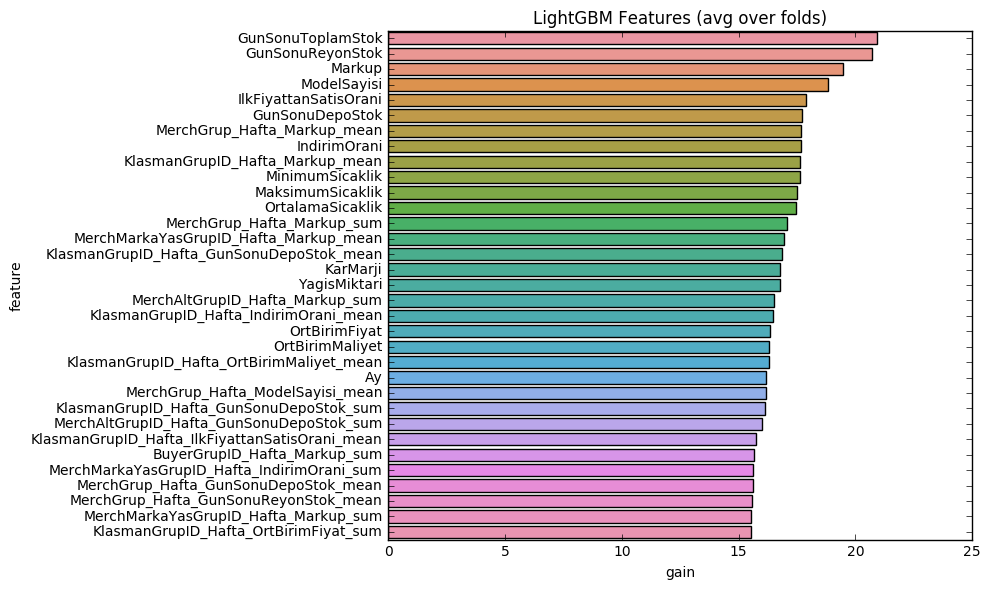

In [130]:
plt.figure(figsize=(10,6))
sns.barplot(x="gain", y="feature", data=imp_df.sort_values(by="gain",ascending=False)[:33])
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances_weekly.png')

In [126]:
imp_df.shape

(241, 2)

In [105]:
mape_valid = train.loc[train.Yil==2015, ["OrtBirimFiyat","SatisAdet"]].copy()

In [119]:
train.head()

,Gun,MagazaID,MerchAltGrupID,UrunKlasmanID,GunSonuReyonStok,GunSonuToplamStok,OrtBirimFiyat,OrtBirimMaliyet,IndirimOrani,IlkFiyattanSatisOrani,KarMarji,Markup,ModelSayisi,SezonGrup,SatisAdet,GunSonuDepoStok,Yil,Ay,Hafta,HaftaninGunu,SehirID_x,MinimumSicaklik,OrtalamaSicaklik,MaksimumSicaklik,YagisMiktari,KarKalinligi,Yagmur,Kar,FarkSicaklik,MerchGrupID,MerchMarkaYasGrupID,UrunKlasmanID_num,BuyerGrupID_num,KlasmanGrupID_num,MagazaID_num,MerchGrupID_11,MerchGrupID_12,MerchGrupID_14,MerchGrupID_15,MerchMarkaYasGrupID_12,MerchMarkaYasGrupID_15,MerchMarkaYasGrupID_31,MerchMarkaYasGrupID_40,MerchMarkaYasGrupID_53,MerchMarkaYasGrupID_62,VucutBolge_Alt,VucutBolge_Tanımsız,VucutBolge_Üst,VucutBolge_ÜstAlt,KlasmanIklimStatu_Baharlık/Dış Giyim,KlasmanIklimStatu_Baharlık/Mevsimlik,KlasmanIklimStatu_Diğer,KlasmanIklimStatu_Kışlık/Diğer,KlasmanIklimStatu_Kışlık/Dış Giyim,KlasmanIklimStatu_Yazlık/K.Kol,KlasmanIklimStatu_Yazlık/Sıcak Yaz,OutletMi,SehirID_y,SehirID_100,SehirID_105,SehirID_110,SehirID_113,SehirID_118,SehirID_126,SehirID_127,SehirID_132,SehirID_154,SehirID_156,CografiBolge_AKDZ,CografiBolge_EGEB,CografiBolge_GAND,CografiBolge_IAND,CografiBolge_KRDZ,CografiBolge_MARM,CaddeAVM_Cadde,CaddeAVM_Mall- Üstü Kapalı,CaddeAVM_Mall-Üstü Açık,bas_ANNELER GUNU,bas_BABALAR GUNU,bas_Black Friday,bas_DUNYA KADINLAR GUNU,bas_KURBAN BAYRAMI,bas_OKUL ACILISI,bas_OKUL KAPANISI,bas_RAMAZAN AYI,bas_RAMAZAN BAYRAMI,bas_SEVGILILER GUNU,bas_YARI YIL TATILI,bas_YIL BASI,bitis_KURBAN BAYRAMI,bitis_RAMAZAN AYI,bitis_RAMAZAN BAYRAMI,bitis_YARI YIL TATILI
0,20170907,367,166,3816,68,68,0.0,0.0,0.0,0.0,0.0,1.0,14,1,0,0,2017,9,37,4,110,17.33,24.08,28.14,0.05,0.0,0.0,0.0,2.50,15,53,2.075979,1.645025,1.853721,3.667626,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,110,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,-116,-81,78,182,-6,11,-90,-103,-74,160,135,116,-3,-75,-72,150
1,20171122,535,16,3602,0,1,0.0,0.0,0.0,0.0,0.0,1.0,0,1,0,1,2017,11,48,3,110,5.27,10.03,11.51,0.20,0.0,1.0,0.0,2.91,12,12,4.840661,4.904707,4.373545,2.232835,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,110,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,172,-157,2,106,-82,-65,-166,175,-150,84,59,40,-79,-151,-148,74
2,20170927,491,188,3417,48,48,0.0,0.0,0.0,0.0,0.0,1.0,6,1,0,0,2017,10,40,3,110,17.88,20.88,25.59,3.96,0.0,1.0,0.0,-1.75,15,62,4.219939,4.769283,3.497618,2.261382,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,110,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,-136,-101,58,162,-26,-9,-110,-123,-94,140,115,96,-23,-95,-92,130
3,20150829,491,86,3798,32,49,0.0,0.0,0.0,0.0,0.0,1.0,2,0,0,17,2015,8,35,6,110,21.14,25.72,30.61,0.00,0.0,0.0,0.0,0.34,11,15,0.537568,1.178181,0.591439,2.261382,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,110,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,-111,-69,818,-174,26,16,-78,-72,-43,169,147,125,29,-44,-41,162
4,20171202,215,174,4052,3,3,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0,0,2017,12,49,6,100,16.30,18.31,20.33,0.00,0.0,0.0,0.0,1.13,15,62,0.029535,0.017975,0.027562,1.987734,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,100,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,162,-167,-8,96,-92,-75,-176,165,-160,74,49,30,-89,-161,-158,64


In [122]:
train["Year"] = train["Gun"].apply(lambda x: str(x)[0:4])

In [123]:
train.Year.head()

0    2017
1    2017
2    2017
3    2015
4    2017
Name: Year, dtype: object

In [124]:
train.groupby("Year")["SatisAdet"].agg("sum")

Year
2014       527557
2015     80970667
2016    102877961
2017    103211393
Name: SatisAdet, dtype: int64

In [125]:
527557+80970667

81498224

In [117]:
train = train.merge(klasman,"left",["MerchAltGrupID","UrunKlasmanID"])

KeyboardInterrupt: 

In [116]:
train[["Gun","MagazaID","MerchAltGrupID","UrunKlasmanID","MerchGrup","MerchGrupID","MerchMarkaYasGrupID",
                  "BuyerGrupID","KlasmanGrupID","VucutBolge","KlasmanIklimStatu"]].nunique()

KeyError: "['MerchGrup' 'BuyerGrupID' 'KlasmanGrupID' 'VucutBolge' 'KlasmanIklimStatu'] not in index"

In [106]:
mape_valid["pred"] = preds
mape_valid.loc[mape_valid["OrtBirimFiyat"]==0, "pred"] = 0
mape_valid.loc[mape_valid["pred"]<0, "pred"] = 0

In [107]:
curr_rmse = sqrt(mean_squared_error(mape_valid.SatisAdet, mape_valid.pred))
curr_mae = mean_absolute_error(mape_valid.SatisAdet, mape_valid.pred)
print('Averall RMSE : %.6f' % (curr_rmse))
print('Averall MAE : %.6f' % (curr_mae))

Averall RMSE : 4.265635
Averall MAE : 1.306929


In [ ]:
def mape(y_true, y_pred): 
    s = pd.Series([np.array(train.loc[train.Yil==2015,"SatisAdet"]),np.array(preds)],index=["ytrue","ypred"])
    df = pd.DataFrame(s.values.tolist(), index=s.index).T
    df["mape"] = np.abs((df["ytrue"] - df["ypred"]) / (df["ytrue"]))
    df.loc[df["ytrue"]==0,"mape"] = 0
    return df.mape.mean()

In [113]:
mape_valid["mape"] = np.abs((mape_valid["SatisAdet"] - mape_valid["pred"]) / (mape_valid["SatisAdet"]))
mape_valid.loc[mape_valid["SatisAdet"]==0,"mape"] = 0

In [108]:
curr_mape = mape(mape_valid.SatisAdet, mape_valid.pred)
print('Averall MAPE : %.6f' % (curr_mape))

KeyboardInterrupt: 

In [114]:
print('Averall RMSE : %.6f' % (curr_rmse))
print('Averall MAPE : %.6f' % (mape_valid["mape"].mean()))
print('Averall MAE : %.6f' % (curr_mae))

Averall RMSE : 4.265635
Averall MAPE : 0.328805
Averall MAE : 1.306929


In [91]:
mape_valid = train.loc[train.Yil==2015, ["OrtBirimFiyat","SatisAdet"]].copy()
mape_valid["pred"] = preds
mape_valid.loc[mape_valid["OrtBirimFiyat"]==0, "pred"] = 0
mape_valid.loc[mape_valid["pred"]<0, "pred"] = 0
curr_rmse = sqrt(mean_squared_error(mape_valid.SatisAdet, mape_valid.pred))
curr_mape = mape(mape_valid.SatisAdet, mape_valid.pred)
curr_mae = mean_absolute_error(mape_valid.SatisAdet, mape_valid.pred)
print('Averall RMSE : %.6f' % (curr_rmse))
print('Averall MAPE : %.6f' % (curr_mape))
print('Averall MAE : %.6f' % (curr_mae))

KeyboardInterrupt: 

In [ ]:
lgb_train = lgb.Dataset(X_train, label=y_train,free_raw_data=False)
lgb_test = lgb.Dataset(X_test, label=y_test,free_raw_data=False)
reg = lgb.train(params,lgb_train,valid_sets=[lgb_train, lgb_test],valid_names=[‘train’, ‘valid’],num_boost_round=100000,early_stopping_rounds= 100,verbose_eval=100)
import pickle
with open("daily_lgbm_2018.pkl", "wb") as f:
   pickle.dump(reg, f)
preds = reg.predict(X_test, num_iteration=reg.best_iteration)
curr_rmse = sqrt(mean_squared_error(y_train, preds))
curr_mae = mean_absolute_error(y_train, preds)
print(‘Averall RMSE : %.6f’ % (curr_rmse))
print(‘Averall MAE : %.6f’ % (curr_mae))

In [ ]:
feats = [f for f in train.columns if f not in FEATS_EXCLUDED]
lgb_train = lgb.Dataset(train.loc[train.Yil<2017, feats], label=train.loc[train.Yil<2017,"SatisAdet"],free_raw_data=False)
lgb_test = lgb.Dataset(train.loc[train.Yil==2017, feats], label=train.loc[train.Yil==2017,"SatisAdet"],free_raw_data=False)
reg = lgb.train(params,lgb_train,valid_sets=[lgb_train, lgb_test],valid_names=['train', 'valid'],num_boost_round=100000,early_stopping_rounds= 100,verbose_eval=100)
import pickle
with open('daily_lgbm_2017.pkl', 'wb') as f:
    pickle.dump(reg, f)
preds = reg.predict(train.loc[train.Yil==2017, feats], num_iteration=reg.best_iteration)
curr_rmse = sqrt(mean_squared_error(train.loc[train.Yil==2017,"SatisAdet"], preds))
curr_mae = mean_absolute_error(train.loc[train.Yil==2017,"SatisAdet"], preds)
print('Averall RMSE : %.6f' % (curr_rmse))
print('Averall MAE : %.6f' % (curr_mae))

Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 4.49594	valid's rmse: 5.04049
[200]	train's rmse: 4.20653	valid's rmse: 4.92936
[300]	train's rmse: 4.06538	valid's rmse: 4.86794
[400]	train's rmse: 3.96655	valid's rmse: 4.83292
[500]	train's rmse: 3.88031	valid's rmse: 4.79126
[600]	train's rmse: 3.80999	valid's rmse: 4.76136
[700]	train's rmse: 3.75551	valid's rmse: 4.73307
[800]	train's rmse: 3.70968	valid's rmse: 4.71222
[900]	train's rmse: 3.66418	valid's rmse: 4.69175
[2000]	train's rmse: 3.40258	valid's rmse: 4.61381
[2100]	train's rmse: 3.38768	valid's rmse: 4.60813
[2200]	train's rmse: 3.37223	valid's rmse: 4.60538
[2300]	train's rmse: 3.35743	valid's rmse: 4.60276
[2400]	train's rmse: 3.34499	valid's rmse: 4.60145
Early stopping, best iteration is:
[2358]	train's rmse: 3.35038	valid's rmse: 4.60048


MemoryError: 

In [27]:
gc.collect()

0

In [35]:
train[feats].head()

,GunSonuReyonStok,GunSonuToplamStok,OrtBirimFiyat,OrtBirimMaliyet,IndirimOrani,IlkFiyattanSatisOrani,KarMarji,Markup,ModelSayisi,SezonGrup,GunSonuDepoStok,Yil,Ay,Hafta,HaftaninGunu,SehirID_x,MinimumSicaklik,OrtalamaSicaklik,MaksimumSicaklik,YagisMiktari,KarKalinligi,Yagmur,Kar,FarkSicaklik,UrunKlasmanID_num,BuyerGrupID_num,KlasmanGrupID_num,MagazaID_num,MerchGrupID_11,MerchGrupID_12,MerchGrupID_14,MerchGrupID_15,MerchMarkaYasGrupID_12,MerchMarkaYasGrupID_15,MerchMarkaYasGrupID_31,MerchMarkaYasGrupID_40,MerchMarkaYasGrupID_53,MerchMarkaYasGrupID_62,VucutBolge_Alt,VucutBolge_Tanımsız,VucutBolge_Üst,VucutBolge_ÜstAlt,KlasmanIklimStatu_Baharlık/Dış Giyim,KlasmanIklimStatu_Baharlık/Mevsimlik,KlasmanIklimStatu_Diğer,KlasmanIklimStatu_Kışlık/Diğer,KlasmanIklimStatu_Kışlık/Dış Giyim,KlasmanIklimStatu_Yazlık/K.Kol,KlasmanIklimStatu_Yazlık/Sıcak Yaz,OutletMi,SehirID_y,SehirID_100,SehirID_105,SehirID_110,SehirID_113,SehirID_118,SehirID_126,SehirID_127,SehirID_132,SehirID_154,SehirID_156,CografiBolge_AKDZ,CografiBolge_EGEB,CografiBolge_GAND,CografiBolge_IAND,CografiBolge_KRDZ,CografiBolge_MARM,CaddeAVM_Cadde,CaddeAVM_Mall- Üstü Kapalı,CaddeAVM_Mall-Üstü Açık,bas_ANNELER GUNU,bas_BABALAR GUNU,bas_Black Friday,bas_DUNYA KADINLAR GUNU,bas_KURBAN BAYRAMI,bas_OKUL ACILISI,bas_OKUL KAPANISI,bas_RAMAZAN AYI,bas_RAMAZAN BAYRAMI,bas_SEVGILILER GUNU,bas_YARI YIL TATILI,bas_YIL BASI,bitis_KURBAN BAYRAMI,bitis_RAMAZAN AYI,bitis_RAMAZAN BAYRAMI,bitis_YARI YIL TATILI
0,68,68,0.00,0.00,0.00,0.00,0.00,1.00,14,1,0,2017,9,37,4,110,17.330000,24.080000,28.14000,0.050000,0.000000,0.000000,0.0,2.500000,2.075979,1.645025,1.853721,3.667626,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,110,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,-116,-81,78,182,-6,11,-90,-103,-74,160,135,116,-3,-75,-72,150
1,0,1,0.00,0.00,0.00,0.00,0.00,1.00,0,1,1,2017,11,48,3,110,5.270000,10.030000,11.51000,0.200000,0.000000,1.000000,0.0,2.910000,4.840661,4.904707,4.373545,2.232835,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,110,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,172,-157,2,106,-82,-65,-166,175,-150,84,59,40,-79,-151,-148,74
2,48,48,0.00,0.00,0.00,0.00,0.00,1.00,6,1,0,2017,10,40,3,110,17.880000,20.880000,25.59000,3.960000,0.000000,1.000000,0.0,-1.750000,4.219939,4.769283,3.497618,2.261382,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,110,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,-136,-101,58,162,-26,-9,-110,-123,-94,140,115,96,-23,-95,-92,130
3,32,49,0.00,0.00,0.00,0.00,0.00,1.00,2,0,17,2015,8,35,6,110,21.140000,25.720000,30.61000,0.000000,0.000000,0.000000,0.0,0.340000,0.537568,1.178181,0.591439,2.261382,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,110,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,-111,-69,818,-174,26,16,-78,-72,-43,169,147,125,29,-44,-41,162
4,3,3,0.00,0.00,0.00,0.00,0.00,1.00,1,0,0,2017,12,49,6,100,16.300000,18.310000,20.33000,0.000000,0.000000,0.000000,0.0,1.130000,0.029535,0.017975,0.027562,1.987734,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,100,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,162,-167,-8,96,-92,-75,-176,165,-160,74,49,30,-89,-161,-158,64
5,138,172,19.43,11.81,0.27,0.16,0.34,-0.65,29,0,34,2015,1,2,7,110,5.150000,10.750000,13.65000,3.240000,0.000000,0.000000,0.0,5.470000,3.118455,2.707800,2.490138,2.103246,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,110,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,119,161,1048,56,256,246,152,158,187,34,13,-10,259,186,189,28
6,18,19,0.00,0.00,0.00,0.00,0.00,1.00,4,1,1,2015,6,26,2,110,17.920000,20.820000,23.92000,1.320000,0.000000,1.000000,0.0,0.890000,0.909781,1.529530,4.915203,2.671365,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,110,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,-44,-2,885,-107,93,83,-11,-5,24,-129,-150,-173,96,23,26,-135
7,47,62,26.95,11.80,0.00,0.00,0.53,-1.28,5,1,15,2017,6,25,4,100,21.840000,28.060000,32.37000,0.000000,0.000000,0.000000,0.0,1.570000,2.691402,2.754867,3.542837,1.987734,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,100,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,-32,3,162,-99,78,95,-6,-19,10,-121,-145,-165,81,9,12,-130
8,125,161,25.42,10.8

In [48]:
gc.collect()

0

In [39]:
del lgb_test
del lgb_train


In [46]:
del train_copy

In [42]:
import pickle
with open('train.pkl', 'wb') as f:
    pickle.dump(train, f)

OverflowError: cannot serialize a bytes object larger than 4 GiB

In [50]:
import pickle
with open('daily_lgbm_2017.pkl', 'wb') as f:
    pickle.dump(reg, f)

In [51]:
def mape(y_true, y_pred): 
    s = pd.Series([np.array(train.loc[train.Yil==2017,"SatisAdet"]),
               np.array(preds)],index=["ytrue","ypred"])

    df = pd.DataFrame(s.values.tolist(), index=s.index).T
    df["mape"] = np.abs((df["ytrue"] - df["ypred"]) / (df["ytrue"]))
    df.loc[df["ytrue"]==0,"mape"] = 0
    return df.mape.mean()

In [ ]:
def mape(y_true, y_pred): 
    s = pd.Series([np.array(train.loc[train.Yil==2017,"SatisAdet"]),
               np.array(preds)],index=["ytrue","ypred"])

    df = pd.DataFrame(s.values.tolist(), index=s.index).T
    df["mape"] = np.abs((df["ytrue"] - df["ypred"]) / (df["ytrue"]))
    df.loc[df["ytrue"]==0,"mape"] = 0
    return df.mape.mean()

preds = reg.predict(train.loc[train.Yil==2017, feats], num_iteration=reg.best_iteration)

mape_valid = train.loc[train.Yil==2017, ["OrtBirimFiyat","SatisAdet"]].copy()
mape_valid["pred"] = preds
mape_valid.loc[mape_valid["OrtBirimFiyat"]==0, "pred"] = 0
mape_valid.loc[mape_valid["pred"]<0, "pred"] = 0
mape_valid2 = mape_valid[mape_valid.SatisAdet!=0]
curr_rmse = sqrt(mean_squared_error(mape_valid.SatisAdet, mape_valid.pred))
curr_mape = mape(mape_valid2.SatisAdet, mape_valid2.pred)
curr_mae = mean_absolute_error(mape_valid.SatisAdet, mape_valid.pred)
print('Averall RMSE : %.6f' % (curr_rmse))
print('Averall MAPE : %.6f' % (curr_mape))
print('Averall MAE : %.6f' % (curr_mae))

In [53]:
preds = reg.predict(train.loc[train.Yil==2017, feats], num_iteration=reg.best_iteration)
curr_rmse = sqrt(mean_squared_error(train.loc[train.Yil==2017,"SatisAdet"], preds))
curr_mae = mean_absolute_error(train.loc[train.Yil==2017,"SatisAdet"], preds)
print('Averall RMSE : %.6f' % (curr_rmse))
print('Averall MAE : %.6f' % (curr_mae))

KeyboardInterrupt: 

In [30]:
mape_valid = train.loc[train.Yil==2017, ["OrtBirimFiyat","SatisAdet"]].copy()
mape_valid["pred"] = preds
mape_valid.loc[mape_valid["OrtBirimFiyat"]==0, "pred"] = 0
mape_valid.loc[mape_valid["pred"]<0, "pred"] = 0
mape_valid2 = mape_valid[mape_valid.SatisAdet!=0]
curr_rmse = sqrt(mean_squared_error(mape_valid.SatisAdet, mape_valid.pred))
curr_mape = mape(mape_valid2.SatisAdet, mape_valid2.pred)
curr_mae = mean_absolute_error(mape_valid.SatisAdet, mape_valid.pred)
print('Averall RMSE : %.6f' % (curr_rmse))
print('Averall MAPE : %.6f' % (curr_mape))
print('Averall MAE : %.6f' % (curr_mae))

NameError: name 'preds' is not defined

In [ ]:
curr_mape = mape(sum(mape_valid.SatisAdet), sum(mape_valid.pred))
print('Averall MAPE : %.6f' % (curr_mape))

In [ ]:
importance_df = pd.DataFrame()
importance_df["feature"] = feats
importance_df["importance"] = np.log1p(reg.feature_importance(importance_type='gain', iteration=reg.best_iteration))
importance_df.sort_values("importance",ascending=False)

In [ ]:
preds = reg.predict(test[feats], num_iteration=reg.best_iteration)

### Blending

In [ ]:
prophet = pd.read_csv("burak/prophet_satis.csv")

### K-Fold

In [ ]:
sub_preds, oof_preds, feature_importance_df, final_rmse = kfold_lightgbm(params,train_main, train_valid, num_folds=3, FEATS_EXCLUDED=FEATS_EXCLUDED)

In [ ]:
mape_df = train_main[["OrtBirimFiyat","SatisAdet"]].copy()
mape_df["pred"] = oof_preds
mape_df.loc[mape_df["OrtBirimFiyat"]<=0, "pred"] = 0

In [ ]:
sqrt(mean_squared_error(mape_df.SatisAdet, mape_df.pred))

In [ ]:
mean_absolute_error(mape_df.SatisAdet, mape_df.pred)

In [ ]:
mape_df2 = mape_df[mape_df.SatisAdet!=0]
mape(mape_df2.SatisAdet, mape_df2.pred)

In [ ]:
mape_valid = train_valid[["OrtBirimFiyat","SatisAdet"]].copy()
mape_valid["pred"] = sub_preds
mape_valid.loc[mape_valid["OrtBirimFiyat"]<=0, "pred"] = 0

In [ ]:
sqrt(mean_squared_error(mape_valid.SatisAdet, mape_valid.pred))

In [ ]:
mean_absolute_error(mape_df.SatisAdet, mape_df.pred)

In [ ]:
mape_valid2 = mape_valid[mape_valid.SatisAdet!=0]
mape(mape_valid2.SatisAdet, mape_valid2.pred)

In [ ]:
feature_importance_df.head()

In [ ]:
imp_select = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance",ascending=False)
imp_select

In [ ]:
# Dropping columns with highly frequent values
cols_to_drop = []
drop_values = []
for col in data_train.columns:
    temp = data_train[col].value_counts(dropna=False, normalize=1)
    if len(temp[temp>0.999].index)>0:
        cols_to_drop.append(col)
        drop_values.append(temp)  
data_train.drop(cols_to_drop, axis = 1, inplace = True)
print(f"These columns were dropped: {cols_to_drop} \n Since they have some values covering 99.9% of its all values")

In [ ]:
corr_matrix = data_train.corr().abs()
corr=corr_matrix.unstack().sort_values(kind="quicksort")
corr=pd.DataFrame(data=corr,columns=['correlation'])
corr=corr[(corr.correlation>0.7) & (corr.correlation<1)].reset_index()
corr.drop_duplicates(subset=['correlation']).sort_values("correlation", ascending = False)

In [ ]:
sub_df = test[["Month_of_Year","ISO_Week_of_ISO_Year","CV_UserID"]].copy()
sub_df["target"] = sub_preds_int

In [ ]:
sub_df.head()

In [ ]:
sub_df.to_csv("Dummies.csv",header=False,sep=";",index=False)